    1) 실시간 위치 인증이 맞는가?
    Users frequently 'check-in' with the app to update their current location, which is then broadcast to their friends.
    -> 실시간 위치인증 맞음. brightkite 또한 실시간 위치인증이 맞다고 함.

    2) 중분류 마치기 -> 아직 진행중. 뉴욕과 도쿄 유저에 대한 데이터셋이 별도로 있는데, 이 경우 카테고리가 보다 적어 

In [1]:
import numpy as np
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import math

In [2]:
# UTC_time 변경 함수

def date_convert(date_to_convert):
    pru = datetime.datetime.strptime(date_to_convert, '%a %b %d %H:%M:%S +0000 %Y')+ datetime.timedelta(hours=-240//60)
    return pru.strftime('%b %d %Y %H:%M:%S')

def tzo_convert(tzo_to_convert):
    return  timedelta(hours=tzo_to_convert/60)

In [3]:
nyc_filepath = 'C:/Users/piai/Desktop/code_file/dataset_WWW2019/dataset_TSMC2014_NYC.csv\dataset_TSMC2014_NYC.csv'
custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")

nyc_data = pd.read_csv(nyc_filepath,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)

nyc_data["utcTimestampOffset"] = nyc_data.utcTimestamp + nyc_data.timezoneOffset.apply(tzo_convert)

nyc_data["hour"] = nyc_data.utcTimestampOffset.dt.hour

# 야행성인지 체크하는 컬럼 생성. 저녁 6시부터 새벽 6시까지 활동한 POI는 야행성 Ture로 표시.
nyc_data["nightlife"] = nyc_data['hour'].apply(lambda x: 'True' if (18 <= x < 24) or (0 <= x < 6)else 'False')

# 요일이 무엇인지 0~6 순서로 설정. 월요일이 0, 일요일이 6.
nyc_data["dayofweek"] = nyc_data.utcTimestampOffset.dt.dayofweek

# 평일과 주말을 구분. 평일이면 True, 주말이면 False.
nyc_data["weekday"] = nyc_data['dayofweek'].apply(lambda x: 'True' if x <= 4 else 'False')

In [7]:
# 카테고리는 519개가 존재한다.
nyc_data['venueCategory'].drop_duplicates().count()

251

In [8]:
nyc_data['venueCategory'].drop_duplicates()

0         Arts & Crafts Store
1                      Bridge
2              Home (private)
3              Medical Center
4                  Food Truck
                 ...         
102807        Photography Lab
110352          Garden Center
139848           Music School
158923                 Castle
167530            Pet Service
Name: venueCategory, Length: 251, dtype: object

<AxesSubplot:xlabel='dayofweek'>

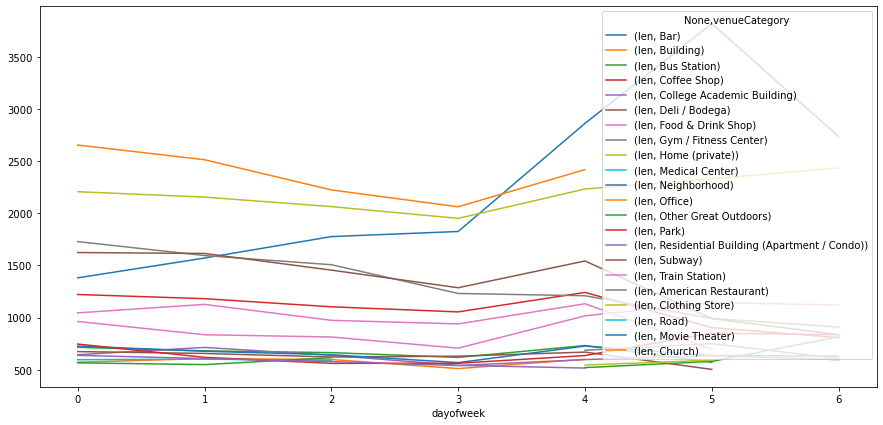

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
pru= nyc_data.groupby([ 'dayofweek','venueCategory']).venueId.agg([len])
pru2 =pru.query('len > 500')
pru2.unstack().plot(ax=ax)

In [11]:
pru.sort_values(['len'], ascending= False).head(60)

,,len
dayofweek,venueCategory,
5,Bar,3822
4,Bar,2864
6,Bar,2737
0,Office,2656
1,Office,2515
6,Home (private),2436
4,Office,2420
5,Home (private),2331
4,Home (private),2234


<AxesSubplot:>

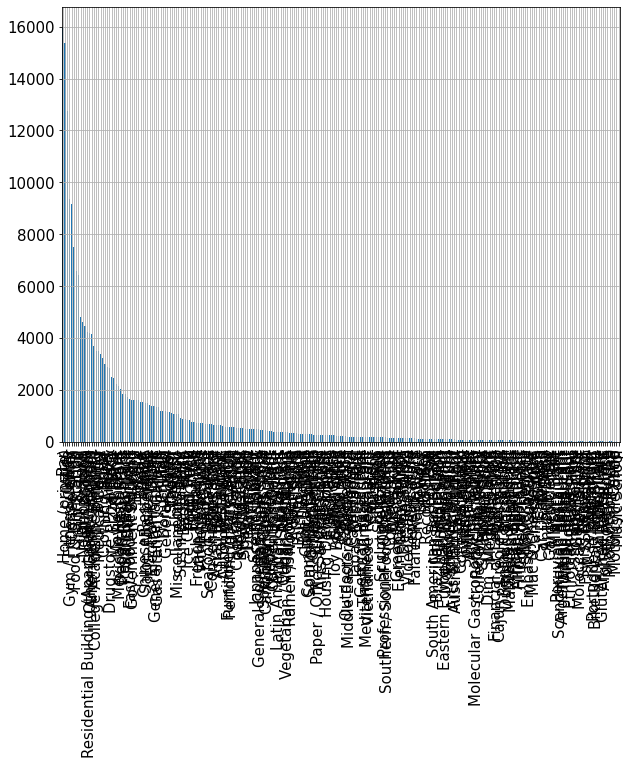

In [12]:
CountStatus = pd.value_counts(nyc_data['venueCategory'], sort=True)
CountStatus.plot.bar()
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15)  # figsize, fontsize 조정

In [13]:
nyc_data.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,2012-04-03 14:00:25,14,False,1,True
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,2012-04-03 14:02:24,14,False,1,True
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41,2012-04-03 14:02:41,14,False,1,True
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00,2012-04-03 14:03:00,14,False,1,True


In [14]:
len(nyc_data['userId'].unique())

1083

In [15]:
len(nyc_data['venueCategory'].unique())

251

In [71]:
# 유저 아이디 별로 정렬 후
# 유저 아이디 행 수만큼만 len 돌려서 time delta 하고,
# 이대로 컬럼 하나 추가하기.
nyc_data_sorted = nyc_data.sort_values(by=['userId', 'utcTimestampOffset'], ascending=[True, True])

In [72]:
nyc_data_sorted.head(10)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
2454,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True
3660,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False
5603,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False
5783,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False
6696,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True
7666,1,3fd66200f964a52094e41ee3,4bf58dd8d48988d1cc941735,Steakhouse,40.734276,-73.993525,-240,2012-04-10 00:24:31,2012-04-09 20:24:31,20,True,0,True
7906,1,42586c80f964a520db201fe3,4bf58dd8d48988d121941735,Bar,40.775986,-73.979528,-240,2012-04-10 03:36:56,2012-04-09 23:36:56,23,True,0,True
8312,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,2012-04-10 16:21:48,2012-04-10 12:21:48,12,False,1,True
11804,1,49d2b43ef964a520cb5b1fe3,4bf58dd8d48988d1e0931735,Coffee Shop,40.720087,-74.003961,-240,2012-04-12 17:19:21,2012-04-12 13:19:21,13,False,3,True
13737,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,2012-04-13 15:41:41,2012-04-13 11:41:41,11,False,4,True


In [73]:
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)

In [74]:
nyc_data_sorted.reset_index(inplace= True, drop= True)
#nyc_data_sorted.drop(['index'], axis=1, inplace= True)

In [75]:
# for i in range(len(nyc_data_sorted) -1):
#    if i == len(nyc_data_sorted) - 1:
#        continue
#    if nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i+1, "userId"]:
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
#        nyc_data_sorted.loc[i+1, 'time_diff'] = pd.to_timedelta(0, unit='h')
#    # if (i > 0) & nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]:
#        # nyc_data_sorted.loc[i, "userId"] = nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
nyc_data_sorted.loc[len(nyc_data_sorted)-1,'time_diff'] = pd.to_timedelta(0, unit='h')

In [76]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227423,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02
227424,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19
227425,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11
227426,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44


In [77]:
nyc_data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   userId              227428 non-null  int64          
 1   venueId             227428 non-null  object         
 2   venueCategoryId     227428 non-null  object         
 3   venueCategory       227428 non-null  object         
 4   latitude            227428 non-null  float64        
 5   longitude           227428 non-null  float64        
 6   timezoneOffset      227428 non-null  int64          
 7   utcTimestamp        227428 non-null  datetime64[ns] 
 8   utcTimestampOffset  227428 non-null  datetime64[ns] 
 9   hour                227428 non-null  int64          
 10  nightlife           227428 non-null  object         
 11  dayofweek           227428 non-null  int64          
 12  weekday             227428 non-null  object         
 13  time_diff     

In [78]:
# !!!!!!!!!!오해의 소지가 있는 poi 중복값 제거를 위해 카테고리 값 수정 작업 코드!!!!!!!!!!!!!
nyc_data_sorted.replace('Sushi Restaurant', 'Japanese Restaurant', inplace= True)

In [59]:
# nyc_data_test = nyc_data_sorted[:]

In [80]:
nyc_data_sorted['duplicate'] = False

In [98]:
import datetime

In [99]:
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [105]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        continue
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    # if (i > 0) & nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]:
        # nyc_data_sorted.loc[i, "userId"] = nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')

In [108]:
# 이 사용자는 저녁만 되면 먹고 논다. 여러번 중복해서 장소인증을 하는 듯 함.
nyc_data_sorted[nyc_data_sorted['userId'] == 470].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
101424,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True,0 days 05:36:25,False,336.416667
101425,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,2012-04-03 19:36:34,19,True,1,True,0 days 00:10:12,False,10.200000
101426,470,4be09b7fcb81c9b62069668b,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.624513,-73.965070,-240,2012-04-03 23:46:46,2012-04-03 19:46:46,19,True,1,True,0 days 00:00:30,True,0.500000
101427,470,49f50c9ff964a5208a6b1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.677611,-73.963748,-240,2012-04-03 23:47:16,2012-04-03 19:47:16,19,True,1,True,0 days 00:00:33,True,0.550000
101428,470,4a6a09b1f964a52071cc1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.702752,-73.990696,-240,2012-04-03 23:47:49,2012-04-03 19:47:49,19,True,1,True,0 days 00:00:26,True,0.433333
101429,470,49e63b62f964a52027641fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.687583,-73.989895,-240,2012-04-03 23:48:15,2012-04-03 19:48:15,19,True,1,True,0 days 00:00:36,True,0.600000
101430,470,45795395f964a520d23e1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.679694,-73.974252,-240,2012-04-03 23:48:51,2012-04-03 19:48:51,19,True,1,True,0 days 00:02:42,True,2.700000
101431,470,4c9d89017ada199cf0a493bc,4bf58dd8d48988d111941735,Japanese Restaurant,40.705436,-74.008348,-240,2012-04-03 23:51:33,2012-04-03 19:51:33,19,True,1,True,0 days 00:00:28,True,0.466667
101432,470,4b5b92def964a5201d0829e3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.599278,-73.990891,-240,2012-04-03 23:52:01,2012-04-03 19:52:01,19,True,1,True,0 days 00:00:24,True,0.400000
101433,470,4baea553f964a5206dca3be3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.657351,-73.956644,-240,2012-04-03 23:52:25,2012-04-03 19:52:25,19,True,1,True,0 days 00:07:57,True,7.950000


In [95]:
nyc_data_sorted[nyc_data_sorted['userId'] == 41].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate
7370,41,4b23fa86f964a520435e24e3,4bf58dd8d48988d1a7941735,College Academic Building,40.683525,-73.978754,-240,2012-06-06 18:00:52,2012-06-06 14:00:52,14,False,2,True,0 days 18:57:35,True
7371,41,4b942cf1f964a520d86c34e3,4bf58dd8d48988d171941735,Event Space,40.817514,-73.955083,-240,2012-06-07 12:58:27,2012-06-07 08:58:27,8,False,3,True,0 days 23:23:55,False
7372,41,4b942cf1f964a520d86c34e3,4bf58dd8d48988d171941735,Event Space,40.817514,-73.955083,-240,2012-06-08 12:22:22,2012-06-08 08:22:22,8,False,4,True,1 days 08:59:40,True
7373,41,4dd91263ae60680f152e754a,4bf58dd8d48988d163941735,Park,40.661168,-73.979069,-240,2012-06-09 21:22:02,2012-06-09 17:22:02,17,False,5,False,0 days 05:06:29,False
7374,41,4fd40649e4b034e1fa5b729a,4bf58dd8d48988d103941735,Home (private),40.602590,-73.988880,-240,2012-06-10 02:28:31,2012-06-09 22:28:31,22,True,5,False,0 days 20:02:53,False
7375,41,4bfdb176b68d0f478e30e957,4bf58dd8d48988d1fc941735,Laundry Service,40.606173,-73.986294,-240,2012-06-10 22:31:24,2012-06-10 18:31:24,18,True,6,False,0 days 19:59:54,False
7376,41,4cab3fc476d3a09333712a6b,4bf58dd8d48988d13b941735,School,40.665677,-73.917712,-240,2012-06-11 18:31:18,2012-06-11 14:31:18,14,False,0,True,0 days 00:42:36,False
7377,41,4c97ee347b9d37049703da85,4bf58dd8d48988d13d941735,High School,40.764334,-73.957849,-240,2012-06-11 19:13:54,2012-06-11 15:13:54,15,False,0,True,0 days 04:03:51,False
7378,41,4fd40649e4b034e1fa5b729a,4bf58dd8d48988d103941735,Home (private),40.602590,-73.988880,-240,2012-06-11 23:17:45,2012-06-11 19:17:45,19,True,0,True,3 days 14:33:23,False
7379,41,4a00fcfcf964a520cb701fe3,4bf58dd8d48988d147941735,Diner,40.669544,-73.986007,-240,2012-06-15 13:51:08,2012-06-15 09:51:08,9,False,4,True,1 days 15:28:18,False


In [85]:
nyc_data_sorted[nyc_data_sorted['userId'] == 688].sort_values('utcTimestampOffset').head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate
145995,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-03 20:08:04,2012-04-03 16:08:04,16,False,1,True,0 days 14:44:25,False
145996,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-04 10:52:29,2012-04-04 06:52:29,6,False,2,True,1 days 00:01:14,False
145997,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-05 10:53:43,2012-04-05 06:53:43,6,False,3,True,2 days 02:29:11,False
145998,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 13:22:54,2012-04-07 09:22:54,9,False,5,False,0 days 04:29:50,False
145999,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-07 17:52:44,2012-04-07 13:52:44,13,False,5,False,0 days 02:02:52,False
146000,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 19:55:36,2012-04-07 15:55:36,15,False,5,False,0 days 03:46:20,False
146001,688,427c0500f964a52099211fe3,4bf58dd8d48988d1df931735,BBQ Joint,40.744378,-73.996205,-240,2012-04-07 23:41:56,2012-04-07 19:41:56,19,True,5,False,0 days 02:48:42,False
146002,688,4123ed80f964a5203b0c1fe3,4bf58dd8d48988d116941735,Bar,40.744525,-73.990908,-240,2012-04-08 02:30:38,2012-04-07 22:30:38,22,True,5,False,0 days 00:57:48,False
146003,688,4aa936ecf964a520815220e3,4bf58dd8d48988d11f941735,Bar,40.744541,-73.990595,-240,2012-04-08 03:28:26,2012-04-07 23:28:26,23,True,5,False,0 days 09:23:12,False
146004,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-08 12:51:38,2012-04-08 08:51:38,8,False,6,False,1 days 06:28:11,False


In [111]:
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [112]:
nyc_data_sorted

,level_0,index,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
0,0,2454,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,0 days 00:00:00,0.000000
1,1,3660,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,2 days 18:10:53,3970.883333
2,2,5603,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,1 days 00:38:05,1478.083333
3,3,5783,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 01:41:41,101.683333
4,4,6696,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 20:18:42,1218.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227423,227423,220748,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,2 days 13:46:19,3706.316667
227424,227424,220756,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,0 days 00:29:02,29.033333
227425,227425,224179,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,5 days 18:49:19,8329.316667
227426,227426,224647,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,0 days 13:37:11,817.183333


## Timedelta를 바탕으로 현 POI와 다음 POI 간 체류시간을 계산 & 다양한 EDA 수행작업 시작

In [118]:
nyc_data_sorted[nyc_data_sorted['venueCategory'] == 'Bar']

,level_0,index,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
6,6,7906,1,42586c80f964a520db201fe3,4bf58dd8d48988d121941735,Bar,40.775986,-73.979528,-240,2012-04-10 03:36:56,2012-04-09 23:36:56,23,True,0,True,0 days 03:12:25,192.416667
10,10,14856,1,46ea2358f964a520cf4a1fe3,4bf58dd8d48988d11d941735,Bar,40.760667,-73.994948,-240,2012-04-14 01:11:20,2012-04-13 21:11:20,21,True,4,True,0 days 09:29:39,569.650000
12,12,15249,1,40fb0f00f964a520d90a1fe3,4bf58dd8d48988d11b941735,Bar,40.760645,-73.986065,-240,2012-04-14 04:45:13,2012-04-14 00:45:13,0,True,5,False,0 days 01:37:17,97.283333
17,17,16600,1,4e742aabc65bb91db3cadb79,4bf58dd8d48988d116941735,Bar,40.757305,-73.968640,-240,2012-04-14 22:07:43,2012-04-14 18:07:43,18,True,5,False,0 days 00:43:35,43.583333
23,23,23899,1,4c12b3d07f7f2d7f11ccdd68,4bf58dd8d48988d11d941735,Bar,40.727503,-74.000634,-240,2012-04-19 02:09:21,2012-04-18 22:09:21,22,True,2,True,0 days 10:02:18,602.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227395,227395,200691,1083,4d5b409222ad2d43527ce695,4bf58dd8d48988d116941735,Bar,40.739098,-73.983000,-300,2012-12-21 21:20:11,2012-12-21 16:20:11,16,False,4,True,0 days 03:11:13,191.216667
227402,227402,206587,1083,4e4e70306365e1419d0205e4,4bf58dd8d48988d116941735,Bar,40.755998,-73.991150,-300,2013-01-04 22:15:09,2013-01-04 17:15:09,17,False,4,True,0 days 04:16:32,256.533333
227415,227415,216357,1083,4bd8df990115c9b618ba7580,4bf58dd8d48988d1d8941735,Bar,40.740787,-73.993319,-300,2013-01-26 00:56:12,2013-01-25 19:56:12,19,True,4,True,11 days 10:51:14,16491.233333
227416,227416,216518,1083,4101a680f964a5205a0b1fe3,4bf58dd8d48988d116941735,Bar,40.740728,-74.008611,-300,2013-01-26 06:34:38,2013-01-26 01:34:38,1,True,5,False,0 days 05:38:26,338.433333


c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

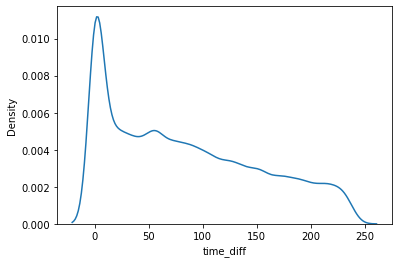

In [137]:
# Pub, Bar 등 술집 방문의 경우,
# 240분 이내(4시간 이내) 인증한 경우를 다음과 같이 분포도 확인하였다.
# 지나치게 짧은 시간은 술집 POI를 여러번 체크인(인증)하였기 때문으로 추측됨.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

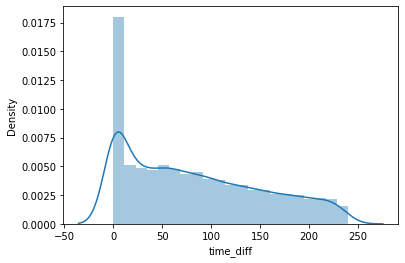

In [135]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240)]['time_diff']/datetime.timedelta(minutes=1))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

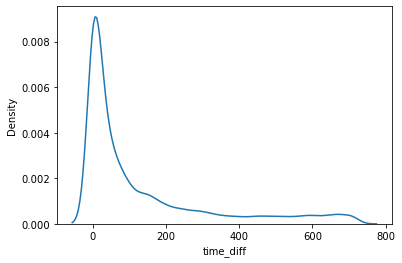

In [134]:
# Office 직장 방문의 경우,
# 720분(12시간) 이내 다른 POI를 인증한 경우를 다음과 같이 분포도 확인하였다.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

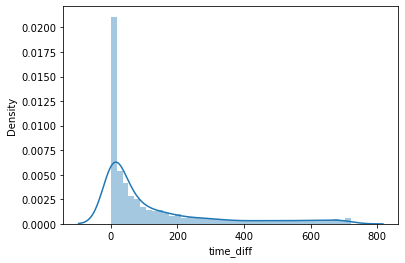

In [133]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

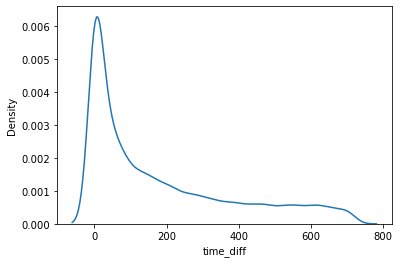

In [139]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Home'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

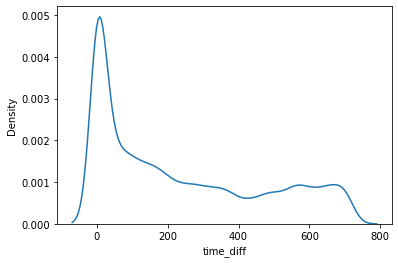

In [140]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Gym'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

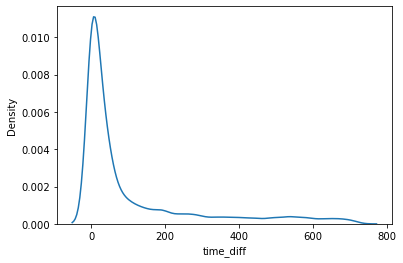

In [141]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Subway'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

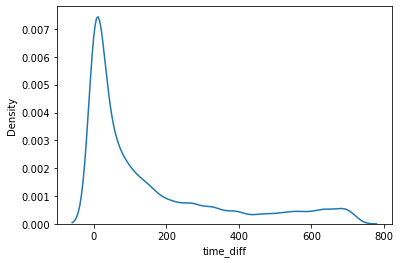

In [142]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Coffee'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

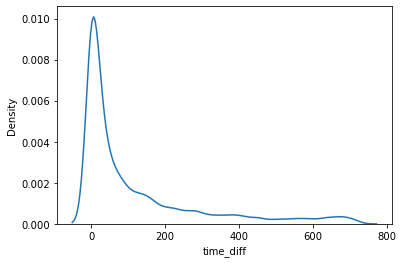

In [144]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Park'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

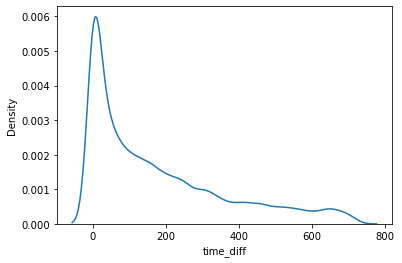

In [143]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Restaurant'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

In [106]:
(nyc_data_sorted[nyc_data_sorted['venueCategory'].str.contains('Bar')
| nyc_data_sorted['venueCategory'].str.contains('Pub')
| nyc_data_sorted['venueCategory'].str.contains('pub')]['time_diff']/datetime.timedelta(minutes=1)).head(100)

6        192.416667
10       569.650000
12        97.283333
17        43.583333
23       602.300000
           ...     
1758     514.833333
2072     447.733333
2086      82.783333
2366    1716.400000
2416     188.166667
Name: time_diff, Length: 100, dtype: float64

In [107]:
nyc_data_sorted.to_csv('refined_nyc_data.csv')